In [2]:
%load_ext autoreload
%autoreload 2

import net
import logic
from data.load import load_genx

from collections import defaultdict
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import seaborn

In [3]:
N_HIDDEN = 256
N_COMM = 64
N_BATCH = 100
MAX_ITEMS = 20

random = np.random.RandomState(0)

In [4]:
def build_model(dataset):
    t_features = tf.placeholder(tf.float32, (None, MAX_ITEMS, len(dataset.attrs)))
    t_labels = tf.placeholder(tf.float32, (None, MAX_ITEMS))

    t_in = tf.concat((t_features, tf.expand_dims(t_labels, axis=2)), axis=2)

    cell = tf.contrib.rnn.GRUCell(N_HIDDEN)
    with tf.variable_scope("enc1"):
        states1, hidden1 = tf.nn.dynamic_rnn(cell, t_in, dtype=tf.float32)
    t_hidden = hidden1
    t_msg = tf.nn.relu(net.linear(t_hidden, N_COMM))

    t_expand_msg = tf.expand_dims(t_msg, axis=1)
    t_tile_message = tf.tile(t_expand_msg, (1, MAX_ITEMS, 1))
    t_out_feats = tf.concat((t_tile_message, t_features), axis=2)
    t_pred = tf.squeeze(
        net.mlp(t_out_feats, (N_HIDDEN, 1), (tf.nn.relu, None)))
    t_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=t_labels, logits=t_pred))

    return t_features, t_labels, t_msg, t_pred, t_loss

In [5]:
def sample_envs(lfs, dataset):
    envs = []
    labels = []
    attrs_by_type = defaultdict(list)
    for attr in dataset.attrs:
        typ = attr.split(":")[1]
        attrs_by_type[typ].append(attr)
    while len(envs) < N_BATCH:
        lf = lfs[random.randint(len(lfs))]
        env = []
        label = []
        accepted = False
        rejected = False
        used = []
        count = random.randint(MAX_ITEMS)
        for j in range(MAX_ITEMS):
            if j >= count:
                env.append(np.zeros(len(dataset.attrs)))
                label.append(0)
                continue
            attrs = np.zeros(len(dataset.attrs))
            for group in attrs_by_type.values():
                val = random.choice(group)
                attrs[dataset.attrs[val]] = 1
            env.append(attrs)
            if logic.eval_lf(attrs, lf, dataset):
                accepted = True
                label.append(1)
            else:
                rejected = True
                label.append(0)
        if not (accepted and rejected):
            continue
        envs.append(env)
        labels.append(label)
    return envs, labels

def sample_annotated(dataset, scene_ids=None):
    envs = []
    labels = []
    if scene_ids is None:
        scene_ids = random.choice(dataset.labels.keys(), size=N_BATCH)
    for scene_id in scene_ids:
        scene = dataset.scenes[scene_id]
        ann = dataset.labels[scene_id]
        assert len(ann) > 0
        lf = ann[random.randint(len(ann))].lf
        env = np.zeros((MAX_ITEMS, len(dataset.attrs)))
        label = np.zeros(MAX_ITEMS)
        assert len(scene.targets) + len(scene.distractors) < MAX_ITEMS
        for j, ent in enumerate(scene.targets):
            for prop in ent.props:
                env[j, dataset.attrs[prop]] = 1
                label[j] = 1
        for j, ent in enumerate(scene.distractors):
            for prop in ent.props:
                env[j + len(scene.targets), dataset.attrs[prop]] = 1
                label[j + len(scene.targets)] = 0
        envs.append(env)
        labels.append(label)
    return envs, labels

In [6]:
dataset = load_genx()

for i_scene, scene in dataset.scenes.items():
    if i_scene not in dataset.labels:
        continue
    for nl, lf in dataset.labels[i_scene]:
        if not all(logic.eval_lf(ent, lf, dataset) for ent in scene.targets):
            print "warning: failed check with", lf
        if any(logic.eval_lf(ent, lf, dataset) for ent in scene.distractors):
            print "warning: failed check with", lf

t_features, t_labels, t_msg, t_pred, t_loss = build_model(dataset)
optimizer = tf.train.AdamOptimizer(0.001)
o_train = optimizer.minimize(t_loss)
session = tf.Session()
session.run(tf.global_variables_initializer())
lfs = list(logic.enumerate_lfs(3, dataset))

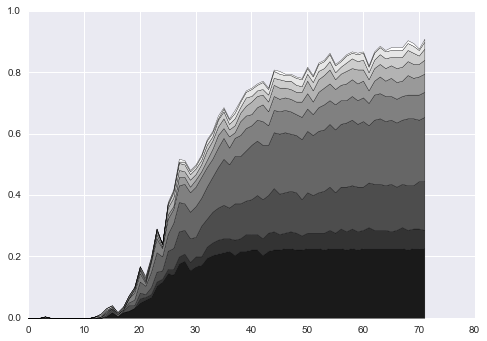

KeyboardInterrupt: 

In [6]:
nl_sizes = []
lf_sizes = []
counts = []
for scene_id, label in dataset.labels.items():
    nl_size = np.mean([len(l.nl) for l in label])
    lf_size = np.mean([len(logic.flatten(l.lf)) for l in label])
    count = len(dataset.scenes[scene_id].targets)
    nl_sizes.append(nl_size)
    lf_sizes.append(lf_size)
    counts.append(count)
nl_sizes = sorted(nl_sizes)
lf_sizes = sorted(lf_sizes)
counts = sorted(counts)
#lf_quantiles = [
#    lf_sizes[int(q * len(lf_sizes))-1]
#    for q in [0.25, 0.5, 0.75, 1]
#]
lf_quantiles = [2.99, 3.25, 6.85, 15]
print counts
#print lf_sizes
def bucket(val, buckets):
    for i, b in enumerate(buckets):
        if val <= b:
            return i
    assert False
    
#print lf_quantiles
#bucket_sizes = defaultdict(lambda: 0)
#for scene_id, label in dataset.labels.items():
#    lf_size = np.mean([len(logic.flatten(l.lf)) for l in label])
#    bucket_sizes[bucket(lf_size, lf_quantiles)] += 1
#print bucket_sizes

    
h_by_nl_size = defaultdict(list)
h_by_lf_size = defaultdict(list)
h_by_count = defaultdict(list)
h_total = []
def h_eval():
    by_nl_size = defaultdict(lambda: 0.)
    by_lf_size = defaultdict(lambda: 0.)
    by_count = defaultdict(lambda: 0.)
    scene_ids = dataset.labels.keys()
    total = 0
    for i in range(0, len(scene_ids), N_BATCH):
        ids_here = scene_ids[i:i+N_BATCH]
        scenes_here = [dataset.scenes[idh] for idh in ids_here]
        labels_here = [dataset.labels[idh] for idh in ids_here]
        envs, labels = sample_annotated(dataset, ids_here)
        preds, = session.run([t_pred], {t_features: envs, t_labels: labels})
        match = (preds > 0) == labels
        exact = np.all(match, axis=1)
        for j in range(len(ids_here)):
            nl_bucket = int(np.mean([len(l.nl) for l in labels_here[j]]) / 2)
            lf_bucket = bucket(np.mean([len(logic.flatten(l.lf)) for l in labels_here[j]]), lf_quantiles)
            count_bucket = int(len(scenes_here[j].targets))
            by_nl_size[nl_bucket] += exact[j]
            by_lf_size[lf_bucket] += exact[j]
            by_count[count_bucket] += exact[j]
            total += exact[j]
    for key in by_nl_size:
        h_by_nl_size[key].append(by_nl_size[key] / len(scene_ids))
    for key in by_lf_size:
        h_by_lf_size[key].append(by_lf_size[key] / len(scene_ids))
    for key in by_count:
        h_by_count[key].append(by_count[key] / len(scene_ids))
    h_total.append(total / len(scene_ids))
    
    #keys = list((sorted(h_by_lf_size.keys())))
    keys = list(sorted(h_by_count.keys()))
    from IPython import display
    plt.stackplot(
        range(len(h_total)),
        #[h_by_lf_size[k] for k in keys],
        [h_by_count[k] for k in keys],
        colors=[str(1.*k/max(keys)) for k in keys])
    display.clear_output(wait=True)
    plt.show()

while True:
    loss = 0
    acc = 0
    ex = 0
    for t in range(100):
        envs, labels = sample_envs(lfs, dataset)
        l, preds, _ = session.run(
                [t_loss, t_pred, o_train],
                {t_features: envs, t_labels: labels})
        match = (preds > 0) == labels
        a = np.mean(match)
        e = np.mean(np.all(match, axis=1))
        loss += l
        acc += a
        ex += e

    #print loss / 100, acc / 100, ex / 100
    h_eval()

In [43]:
literal_mean = 0
best_lf_mean = 0

def tuplize(lol):
    if not isinstance(lol, list):
        return lol
    return tuple(tuplize(l) for l in lol)

exact = []

correct = 0
for scene_id, labels in dataset.labels.items():
    target_scene = dataset.scenes[scene_id]
    target_env, target_labels = sample_annotated(dataset, [scene_id])
    target_env = np.asarray(target_env)
    envs, _ = sample_annotated(dataset, [scene_id] + list(random.choice(dataset.labels.keys(), size=9)))
    envs = np.asarray(envs)
    
    message = session.run([t_msg], {t_features: target_env, t_labels: target_labels})[0][0, :]
    tile_message = np.asarray([message for _ in range(10)])
    
    model_pred, = session.run([t_pred], {t_features: envs, t_msg: tile_message})
    model_pred = (model_pred > 0).astype(int)
    
    literal_pred = np.zeros((10, MAX_ITEMS), dtype=int)
    for i_env in range(10):
        for i_ent in range(MAX_ITEMS):
            if not target_env[0, i_ent, :].any():
                continue
            literal_pred[i_env, i_ent] = any(
                (envs[i_env, i_ent, :] == target_env[0, i, :]).all() 
                    and target_labels[0][i]
                for i in range(MAX_ITEMS))
            
    if not (model_pred[:1, ...] == target_labels).all():
        continue
        
    correct += 1
            
    literal_mean += np.mean(np.all(model_pred == literal_pred, axis=1))
            
    scene_lfs = [l.lf for l in labels]
    #scene_lfs = [min(scene_lfs, key=lambda x: len(logic.flatten(x)))]
    #scene_lfs = [scene_lfs[random.randint(len(scene_lfs))]]
    #if False:
    #    scene_lf_counts = defaultdict(lambda: 0)
    #    for lf in scene_lfs:
    #        scene_lf_counts[tuplize(lf)] += 1
    #    scene_lfs = [max(scene_lf_counts.items(), key=lambda x: x[1])[0]]
    lf_scores = []
    for lf in scene_lfs:
        lf_score = 0
        for i_env in range(10):
            ok = True
            for i_ent in range(MAX_ITEMS):
                if not any(envs[i_env, i_ent, :]):
                    continue
                ev = 1 if logic.eval_lf(envs[i_env, i_ent, :], lf, dataset) else 0
                if ev != model_pred[i_env, i_ent]:
                    ok = False
                    break
            if ok:
                lf_score += 1
        lf_scores.append((lf_score / 10., lf))
        
    best_score, best_lf = max(lf_scores, key=lambda x: x[0])
    best_lf_mean += best_score
    if best_score > 0.9:
        exact.append((message, lf))
    #print best_score, best_lf
    #print best_lf, scene_lfs
    
print literal_mean / correct
print best_lf_mean / correct

print len(exact), "/", len(dataset.labels)

0.454
0.7155
67 / 220


['or', 'brown:color', 'brown:color']
['or', 'brown:color', 'brown:color']


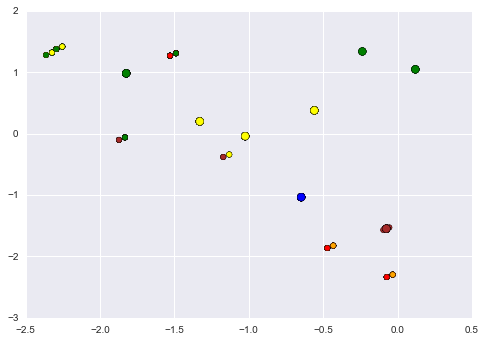

In [31]:
from sklearn.decomposition import PCA

messages = [m for m, l in exact]
proj_messages = PCA(2).fit_transform(messages)
#print proj_messages

COLORS = ["red:color", "green:color", "blue:color", "orange:color", "brown:color", "yellow:color"]

color_messages = []
color_lfs = []
colors = []
sizes = []
for i, (m, l) in enumerate(exact):
    if l in COLORS:
        color_messages.append(proj_messages[i, :])
        color_lfs.append(l)
        colors.append(l.split(":")[0])
        sizes.append(60)
    if len(l) == 3 and l[0] == "or" and l[1] in COLORS and l[2] in COLORS:
        color_messages.append(proj_messages[i, :] + [0.02, 0.02])
        color_messages.append(proj_messages[i, :] - [0.02, 0.02])
        if l[1] == l[2]:
            print l
        colors.append(l[1].split(":")[0])
        colors.append(l[2].split(":")[0])
        sizes.append(30)
        sizes.append(30)
color_messages = np.asarray(color_messages)

plt.scatter(color_messages[:, 0], color_messages[:, 1], c=colors, s=sizes)
plt.show()

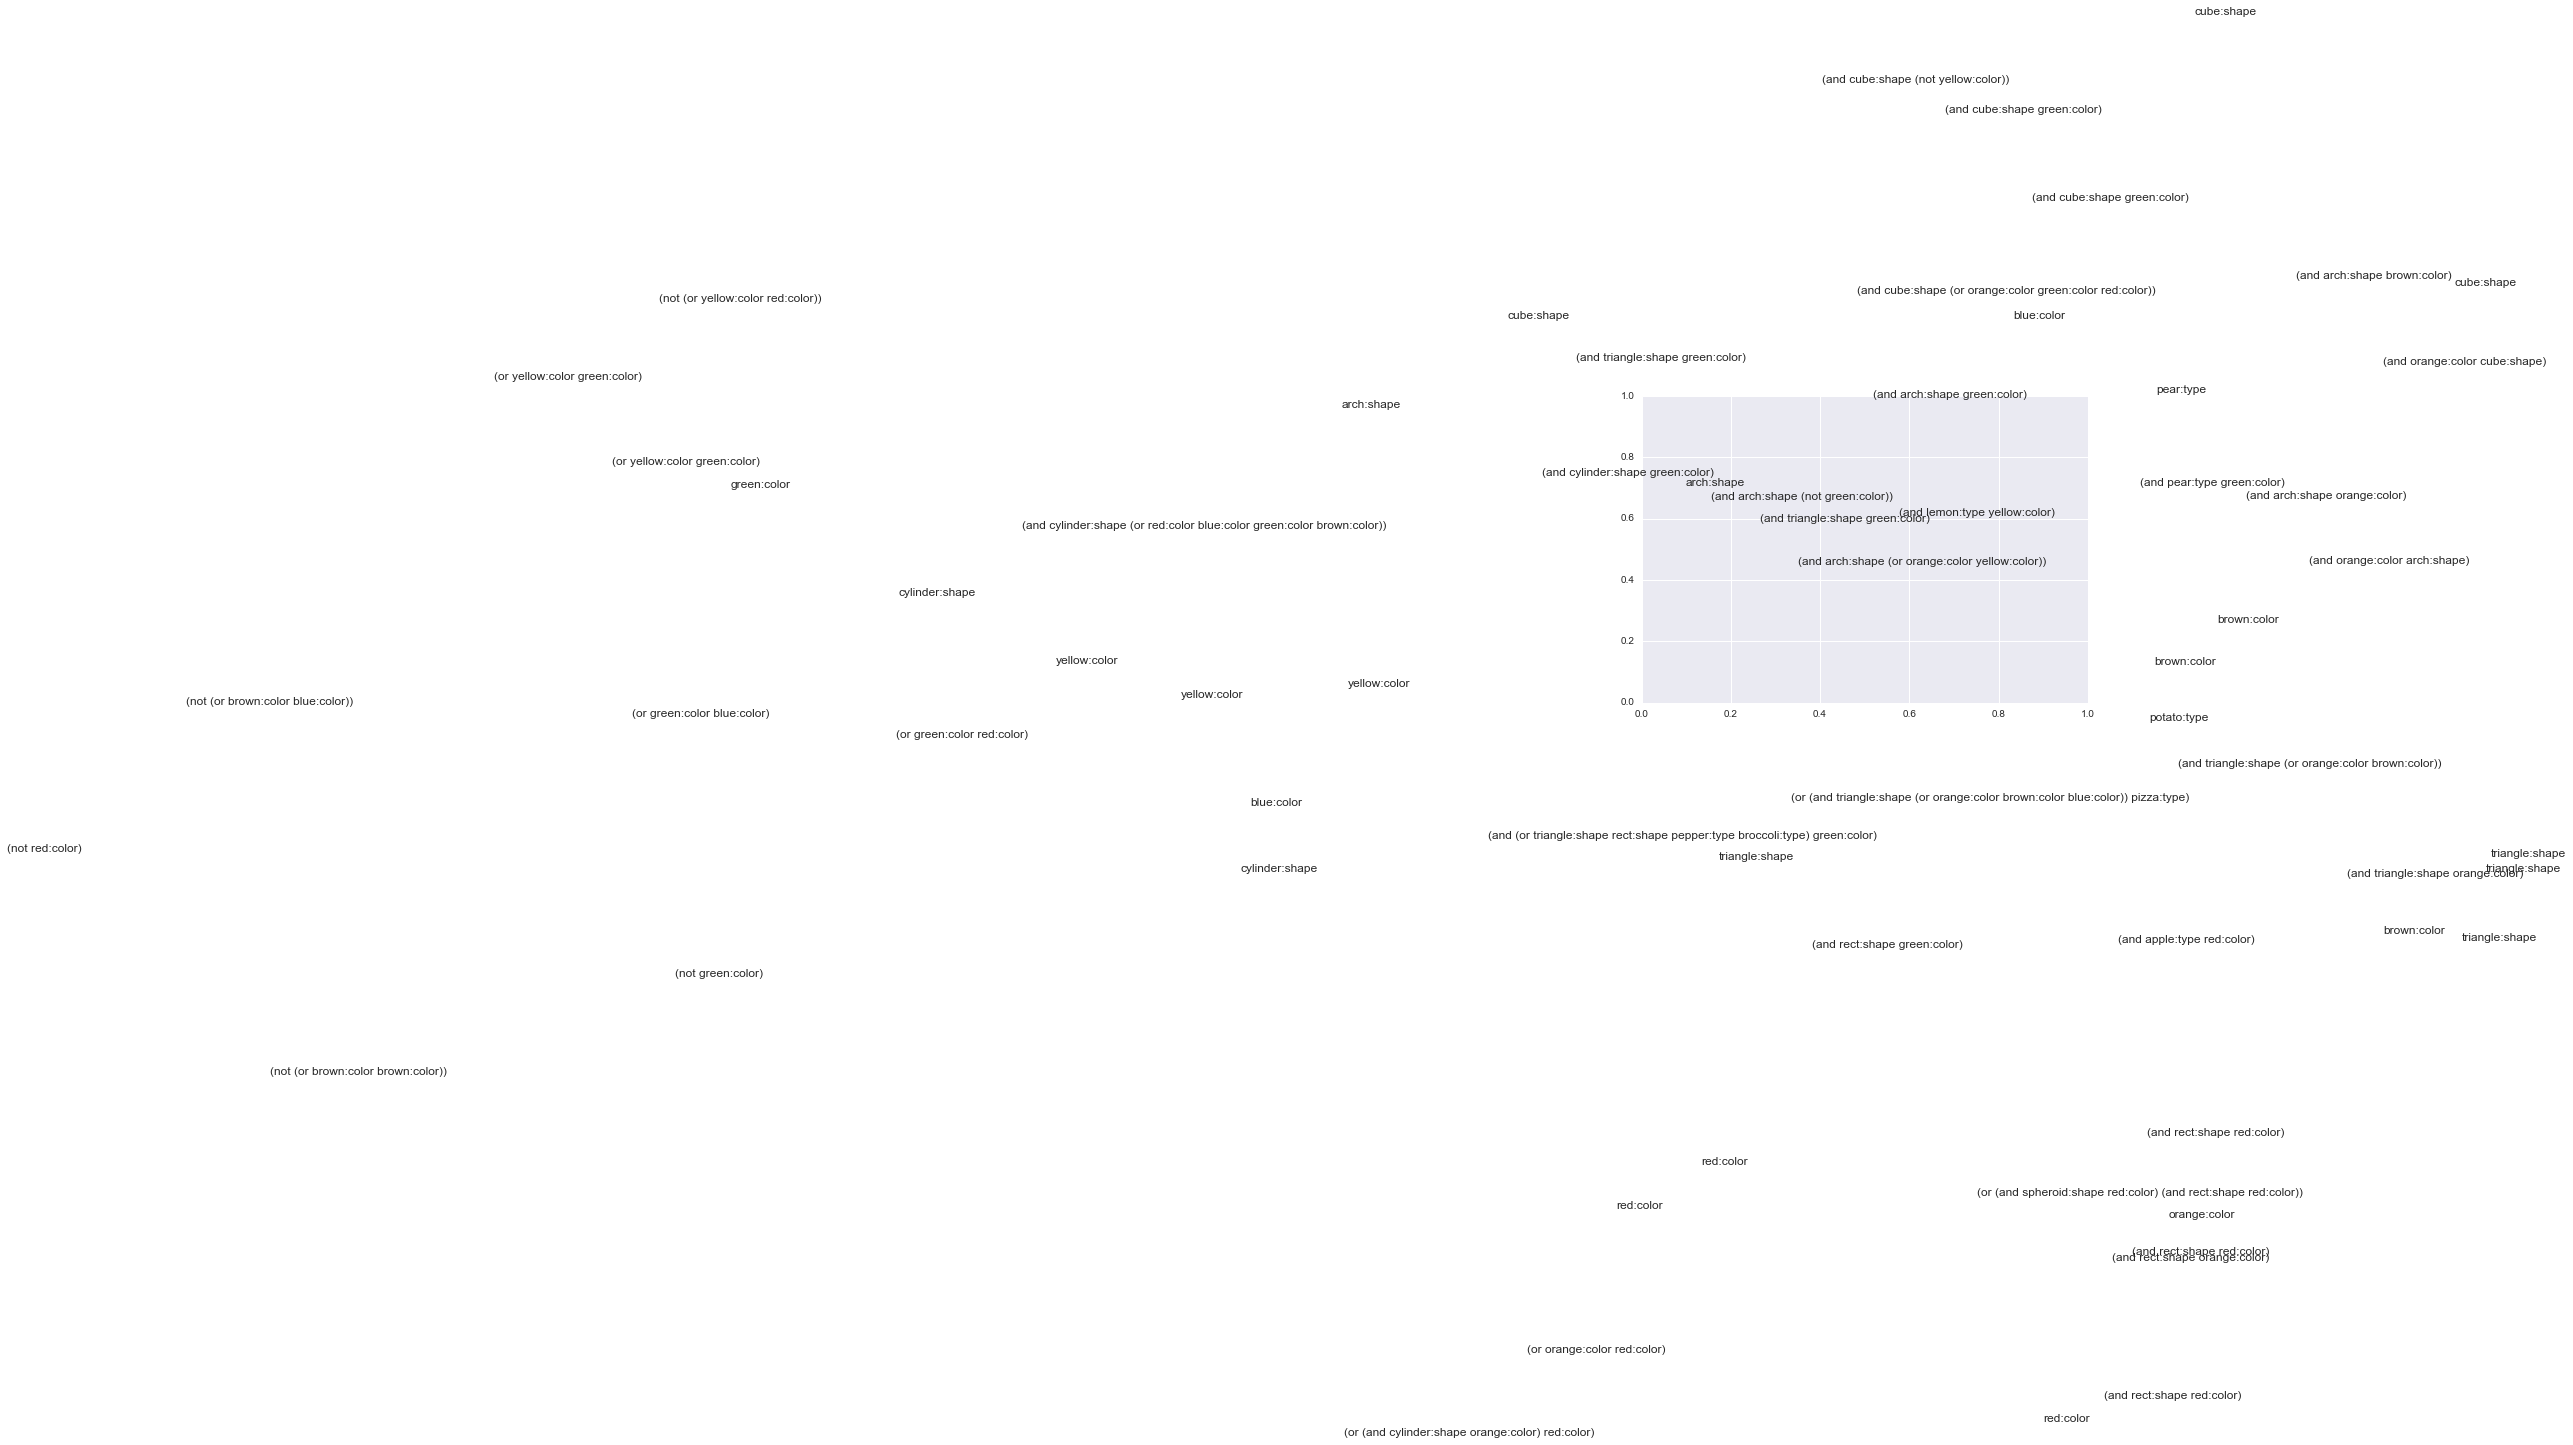

In [45]:
from sklearn.decomposition import PCA

messages = [m for m, l in exact]
proj_messages = PCA(2).fit_transform(messages)
#print proj_messages

keep_lfs = []
keep_coords = []
for i, (m, l) in enumerate(exact):
    if isinstance(l, str) or len(logic.flatten(l)) <= 3:
        keep_lfs.append(logic.pp(l))
        keep_coords.append(proj_messages[i, :] + random.uniform(-0.1, 0.1, 2))
keep_coords = np.asarray(keep_coords)

for i in range(len(keep_lfs)):
    plt.text(keep_coords[i, 0], keep_coords[i, 1], keep_lfs[i])
plt.show()

In [26]:
def explain_env(env, label, lfs):
    valid = []
    for lf in lfs:
        ok = True
        for i in range(env.shape[0]):
            if not any(env[i]):
                continue
            ev = 1 if logic.eval_lf(env[i], lf, dataset) else 0
            if ev != label[i]:
                ok = False
                break
        if ok:
            valid.append(lf)
    return min(valid, key=lambda x: 1 if isinstance(x, int) else len(logic.flatten(x)))

In [9]:
saver = tf.train.Saver()
saver.save(session, "model")

'model'

In [10]:
saver = tf.train.Saver()
saver.restore(session, "saves/model")

In [ ]:
def make_matching_messages(lfs):
    for lf in lfs:
        